# Understanding Factor Analysis (FA)

## Introduction
Factor Analysis (FA) is a statistical method used for dimensionality reduction and exploratory data analysis. It models observed variables as linear combinations of potential factors plus unique noise terms, aiming to uncover the underlying relationships between variables.

## Mathematical Foundations

### Model Assumptions
Factor Analysis assumes that observed variables $X_i$ can be expressed as:

$ X = LF + \epsilon $

where:
- $X$ is the vector of observed variables.
- $L$ is the loading matrix, representing the weights of the factors.
- $F$ is the vector of latent factors.
- $\epsilon$ is the vector of unique variances (errors) for each observed variable.

### Covariance Structure
The covariance matrix $\Sigma$ of the observed variables can be decomposed as:

$ \Sigma = LL^T + \Psi $

where:
- $L$ is the factor loading matrix.
- $\Psi$ is the diagonal matrix of unique variances.

### Estimation
The parameters $L$ and $\Psi$ are estimated to maximize the likelihood of the observed data under the assumed model. This involves iterative algorithms like Expectation-Maximization (EM).

## Steps in Factor Analysis

1. **Standardize the Data**: Scale features to have zero mean and unit variance.
2. **Compute the Covariance Matrix**: Calculate the covariance matrix of the standardized data.
3. **Estimate Factor Loadings**: Use iterative methods to estimate the factor loadings $L$ and unique variances $\Psi$.
4. **Transform Data**: Project the original data onto the factor loadings to obtain the factor scores.

## Arguments in `FactorAnalysis`

- `n_components`: The number of factors to extract. It determines the dimensionality of the latent space.
- `tol`: Tolerance for the stopping criterion.
- `max_iter`: Maximum number of iterations for the EM algorithm.
- `svd_method`: Method to use for computing the SVD (e.g., 'lapack' or 'randomized').

## Example Feature Mapping
For a dataset with features $X_{i,j}$, Factor Analysis decomposes each feature as a linear combination of factors plus noise:

$ X_{i,j} = \sum_{k=1}^{m} L_{j,k} F_{i,k} + \epsilon_{i,j} $

where $m$ is the number of factors, $L_{j,k}$ are the factor loadings, and $F_{i,k}$ are the factor scores.

## When to Use Factor Analysis
- **Exploratory Data Analysis**: Use FA to uncover the underlying structure of the data and identify latent factors.
- **Dimensionality Reduction**: FA is useful when the goal is to reduce the number of observed variables while retaining the variability in the data.
- **Modeling Relationships**: FA can be used to model the relationships between observed variables through latent factors.

```python
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=2)
X_reduced = fa.fit_transform(X_standardized)


In [1]:
# Authors: Alexandre Gramfort
#          Denis A. Engemann
# License: BSD 3 clause

## Create the data



In [2]:
import numpy as np
from scipy import linalg

n_samples, n_features, rank = 500, 25, 5
sigma = 1.0
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.0
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

## Fit the models



best n_components by PCA CV = 5
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 5
best n_components by PCA CV = 20
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 18


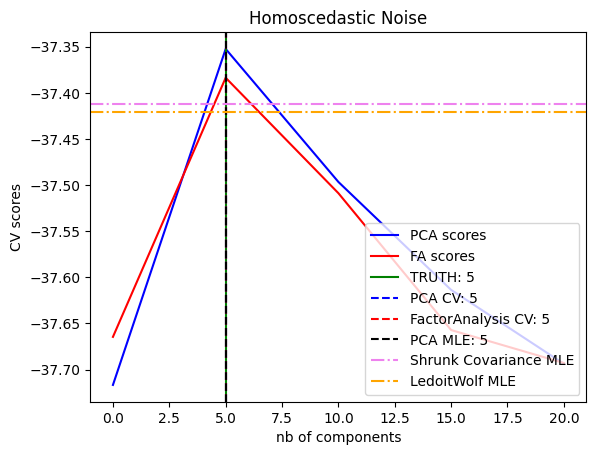

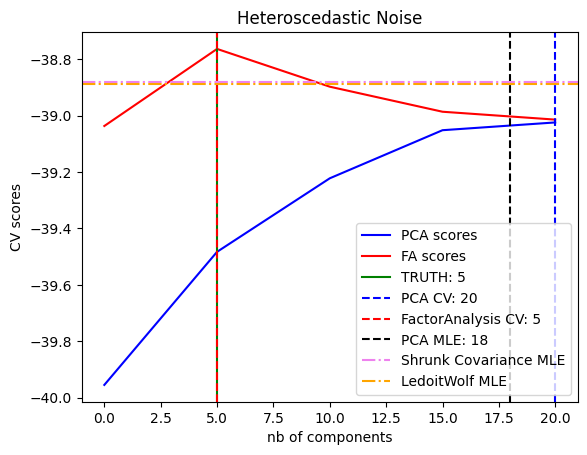

In [3]:
import matplotlib.pyplot as plt

from sklearn.covariance import LedoitWolf, ShrunkCovariance
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score

n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver="full")
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


for X, title in [(X_homo, "Homoscedastic Noise"), (X_hetero, "Heteroscedastic Noise")]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver="full", n_components="mle")
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, "b", label="PCA scores")
    plt.plot(n_components, fa_scores, "r", label="FA scores")
    plt.axvline(rank, color="g", label="TRUTH: %d" % rank, linestyle="-")
    plt.axvline(
        n_components_pca,
        color="b",
        label="PCA CV: %d" % n_components_pca,
        linestyle="--",
    )
    plt.axvline(
        n_components_fa,
        color="r",
        label="FactorAnalysis CV: %d" % n_components_fa,
        linestyle="--",
    )
    plt.axvline(
        n_components_pca_mle,
        color="k",
        label="PCA MLE: %d" % n_components_pca_mle,
        linestyle="--",
    )

    # compare with other covariance estimators
    plt.axhline(
        shrunk_cov_score(X),
        color="violet",
        label="Shrunk Covariance MLE",
        linestyle="-.",
    )
    plt.axhline(
        lw_score(X),
        color="orange",
        label="LedoitWolf MLE" % n_components_pca_mle,
        linestyle="-.",
    )

    plt.xlabel("nb of components")
    plt.ylabel("CV scores")
    plt.legend(loc="lower right")
    plt.title(title)

plt.show()


# Model selection with Probabilistic PCA and Factor Analysis (FA)

Probabilistic PCA and Factor Analysis are probabilistic models.
The consequence is that the likelihood of new data can be used
for model selection and covariance estimation.
Here we compare PCA and FA with cross-validation on low rank data corrupted
with homoscedastic noise (noise variance
is the same for each feature) or heteroscedastic noise (noise variance
is the different for each feature). In a second step we compare the model
likelihood to the likelihoods obtained from shrinkage covariance estimators.

One can observe that with homoscedastic noise both FA and PCA succeed
in recovering the size of the low rank subspace. The likelihood with PCA
is higher than FA in this case. However PCA fails and overestimates
the rank when heteroscedastic noise is present. Under appropriate
circumstances (choice of the number of components), the held-out
data is more likely for low rank models than for shrinkage models.

The automatic estimation from
Automatic Choice of Dimensionality for PCA. NIPS 2000: 598-604
by Thomas P. Minka is also compared.


# Understanding `cross_val_score` with PCA and Factor Analysis

## Introduction
In scikit-learn, `cross_val_score` is used to evaluate a model by performing cross-validation. When applied to dimensionality reduction techniques like Principal Component Analysis (PCA) and Factor Analysis (FA), it assesses the performance of these models on the given data.

## Cross-Validation Overview
Cross-validation is a technique to assess the generalizability of a model by partitioning the data into training and test sets multiple times. It provides a more robust measure of model performance compared to a single train-test split.

## Mathematical Foundations

### Cross-Validation Process
For $k$-fold cross-validation:
1. **Split the Data**: The dataset is divided into $k$ subsets (folds).
2. **Train and Validate**: The model is trained on $k-1$ folds and validated on the remaining fold. This process is repeated $k$ times, each time with a different fold as the validation set.
3. **Compute the Score**: The performance metric is computed for each fold, and the average score is reported.

## PCA and Factor Analysis with `cross_val_score`

### Principal Component Analysis (PCA)
When `cross_val_score(pca, X)` is called:
1. **Model Initialization**: PCA is initialized with a specified number of components (e.g., `n_components=5`).
2. **Data Transformation**: PCA transforms the data by projecting it onto the principal components.
3. **Cross-Validation**: For each fold, the reconstruction error is computed, which measures how well the principal components reconstruct the data.

The output is the mean negative log-likelihood across all folds.

### Factor Analysis (FA)
When `cross_val_score(fa, X)` is called:
1. **Model Initialization**: FA is initialized with a specified number of components (e.g., `n_components=5`).
2. **Data Transformation**: FA models the covariance structure of the data and transforms it by projecting it onto the latent factors.
3. **Cross-Validation**: For each fold, the log-likelihood of the data under the FA model is computed, indicating how well the model explains the data.

The output is the mean negative log-likelihood score across all folds.

## Mathematical Computations

### PCA
For PCA with $n$ components:
- **Reconstruction Error**: The negative log-likelihood of the data given the principal components.

$\ \text{Reconstruction Error} = - \frac{1}{2} \left( \sum_{i=1}^{N} \sum_{j=1}^{d} \left( x_{ij} - \hat{x}_{ij} \right)^2 \right) $

where $x_{ij}$ are the original data points and $\hat{x}_{ij}$ are the reconstructed data points from the principal components.

### FA
For FA with $n$ factors:
- **Log-Likelihood**: The log-likelihood of the observed data under the factor model.

$\ \log p(X) = -\frac{1}{2} \left( N \log \det \Sigma + \text{tr}(S \Sigma^{-1}) + N \log 2\pi \right) $

where $\Sigma = LL^T + \Psi$, $S$ is the sample covariance matrix, $N$ is the number of observations, $L$ is the loading matrix, and $\Psi$ is the diagonal matrix of unique variances.

## Example Code

```python
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score

pca = PCA(n_components=5)
fa = FactorAnalysis(n_components=5)

# Cross-validation scores for PCA
pca_scores = cross_val_score(pca, X, cv=5)

# Cross-validation scores for Factor Analysis
fa_scores = cross_val_score(fa, X, cv=5)


In [5]:
pca = PCA(svd_solver="full")
fa = FactorAnalysis()
pca.n_components = 5
fa.n_components = 5
pca_scores.append(np.mean(cross_val_score(pca, X)))
fa_scores.append(np.mean(cross_val_score(fa, X)))
pca_scores

[-39.95508022117194,
 -39.483133036140956,
 -39.22237037297575,
 -39.051819143840596,
 -39.02427934090561,
 -39.483133036140956,
 -39.483133036140956]

In [7]:
cross_val_score(pca, X)

array([-39.19553608, -40.12588685, -39.89529118, -38.80309072,
       -39.39586035])